In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import multivariate_normal, normal
import faiss, sklearn
from scipy.optimize import minimize
%matplotlib widget

In [2]:
# two normal distributions (two classes) but one runs in a circle over time
lenght_cycle = 100
theta = np.linspace(0, 2*np.pi, lenght_cycle)
radius = 5
a = radius*np.cos(theta)
b = radius*np.sin(theta)
X=np.zeros((lenght_cycle*2,2))
my=np.zeros((lenght_cycle*2,3))
t=np.zeros((lenght_cycle*2))
for i in range(lenght_cycle):
    mean = [radius*np.cos(theta[i]), radius*np.sin(theta[i])]
    cov = [[1, 0], [0, 1]]
    X[2 * i+1, :] = multivariate_normal(mean, cov, size=1)
    X[(2 * i), :] = multivariate_normal([0, 0], cov, size=1)
    my[2 * i+1, 0] = 1 - min(0.5, normal(0, 0.3, size=1)[0] ** 2) # a little bit of uncertainty
    my[(2 * i), 1] = 1 - min(0.5, normal(0, 0.3, size=1)[0] ** 2) # a little bit of uncertainty
    t[2 * i+1] = i
    t[(2 * i)] = i
my[:,2] = 1 - my[:,0] - my[:,1]

In [3]:
k = 5
n = X.shape[0]
D = np.zeros((n,k))
I = np.zeros((n,k))
index = faiss.IndexFlatL2(X.shape[1])
index.add(np.ascontiguousarray(X[:k, :],
                               dtype=np.float32))  # should convert once to arrays np.float out of loop.
for i in range(k+1, n):
    D[i, :], I[i, :] = index.search(np.ascontiguousarray(X[i, :].reshape(1, 2), dtype=np.float32), k=5)
    index.add(np.ascontiguousarray(X[i,:].reshape(1,2), dtype=np.float32))  # should convert once to arrays np.float out of loop.

I = I.astype(int)
T = np.expand_dims(t, axis=1) - t[I] # relative time difference of neighbor j to observation i

pl = my[:,:2] + np.expand_dims(my[:,2],axis=1)

In [4]:
def Gradient(decays, I, D, pl, T):
    dists = D ** 2
    times = T ** 2
    k = I.shape[1]
    alpha = 1 / (1 + np.exp(decays[0]))
    gamma = decays[1:3] ** 2
    tau = decays[3:5] ** 2
    beta = alpha * (np.exp(-gamma.reshape(1, 1, 2) * dists.reshape(dists.shape[0], dists.shape[1], 1))) * np.exp(-tau.reshape(1, 1, 2) * times.reshape(dists.shape[0], dists.shape[1], 1))
    discounted_pl = 1 - beta + (beta * pl[I])
    hat_pl = discounted_pl[:, 0, :]
    for n in range(1, k - 1):
        hat_pl = hat_pl * discounted_pl[:, n, :]
    norm_hat_pl = hat_pl / (hat_pl.sum(axis=1).reshape(hat_pl.shape[0], 1))
    # gradient calculation cf Algorithm 3 Denoeux et al. 2019
    a4 = pl / np.expand_dims((norm_hat_pl * pl).sum(axis=1), axis=1)  # A.4 (i,q)
    a8 = (np.expand_dims(-hat_pl, axis=1) * (1 - pl[I])) / (
            1 - (beta * (1 - pl[I])))  # A.8 (i,K,q) !!! not ok check denominator
    a9 = - beta * np.expand_dims(dists, axis=2)  # A.9 (i,K,q)
    a9t = - beta * np.expand_dims(times, axis=2)
    a13 = beta / alpha  # A.13 (i,K,q)
    a7 = (a8 * a9).sum(axis=1)  # A.7 (i,q)
    a7t = (a8 * a9t).sum(axis=1)
    a12 = (a8 * a13).sum(axis=1)  # A.12 (i,q)
    a6_1 = (1 - norm_hat_pl) / (hat_pl.sum(axis=1).reshape(hat_pl.shape[0], 1))  # (i,q=0,k=0) & (i,q=1,k=1)
    a6_2 = -hat_pl / (hat_pl.sum(axis=1).reshape(hat_pl.shape[0], 1) ** 2)  # (i,q=0,k=1) & (i,q=1,k=0)
    a6 = np.stack((np.stack((a6_1[:, 0], a6_2[:, 0]), axis=1),
                   np.stack((a6_2[:, 1], a6_1[:, 1]), axis=1)),
                  axis=2)  # (i,k,q)
    a5 = a6 * np.expand_dims(a7, axis=2)  # (i,k,q)
    a5t = a6 * np.expand_dims(a7t, axis=2)
    a3 = 2 * np.expand_dims(decays[1:3], axis=0) * (np.expand_dims(a4, axis=1) * a5).sum(
        axis=2)  # (i,k)
    a3t = 2 * np.expand_dims(decays[3:5], axis=0) * (np.expand_dims(a4, axis=1) * a5t).sum(
        axis=2)  # (i,k)
    a11 = (a6 * np.expand_dims(a12, axis=2)).sum(axis=1)
    a10 = -alpha * (1 - alpha) * (a4 * a11).sum(axis=1) # NB: the '-' is omitted in the original paper (typo)
    a1 = a3.sum(axis=0)
    a1t = a3t.sum(axis=0)
    a2 = a10.sum(axis=0)
    return np.concatenate((np.array([a2]),a1, a1t))
def eloglik(decays, I, D , pl, T):
    dists = D ** 2
    times = T ** 2 # if missing just set to 0 and we have back the original algo
    k = I.shape[1]
    alpha = 1 / (1 + np.exp(decays[0]))
    gamma = decays[1:3] ** 2
    tau = decays[3:5] ** 2
    beta = alpha * (np.exp(-gamma.reshape(1, 1, 2) * dists.reshape(dists.shape[0], dists.shape[1], 1))) * np.exp(
        -tau.reshape(1, 1, 2) * times.reshape(dists.shape[0], dists.shape[1], 1))
    discounted_pl = 1 - beta + (beta * pl[I])
    hat_pl = discounted_pl[:, 0, :]
    for n in range(1, k - 1):
        hat_pl = hat_pl * discounted_pl[:, n, :]
    norm_hat_pl = hat_pl / (hat_pl.sum(axis=1).reshape(hat_pl.shape[0], 1))
    # auc
    #fpr, tpr, thresholds = sklearn.metrics.roc_curve(np.round(pl)[:,0], norm_hat_pl[:,0])
    #print(sklearn.metrics.auc(fpr, tpr))
    #print(np.sum(np.log((norm_hat_pl * pl).sum(axis=1))))
    return -np.sum(np.log((norm_hat_pl * pl).sum(axis=1)))
def predict_eknn(decays, I, D, my, T):
    nb = I
    dists = D ** 2 #preds[0]
    times = T ** 2
    k = nb.shape[1]
    alpha = 1 / (1 + np.exp(decays[0]))
    gamma = decays[1:3] ** 2
    tau = decays[3:5] ** 2
    m0 = my[nb][:,:,0] * alpha * (np.exp(-gamma[0] * dists)) * (np.exp(-tau[0] * times))
    m1 = my[nb][:,:,1] * alpha * (np.exp(-gamma[1] * dists)) * (np.exp(-tau[1] * times))
    m10 = 1 - m0 - m1
    m0t = m0[:,0]
    m1t = m1[:,0]
    m10t = m10[:,0]
    for n in range(k-1):
        denominators = 1 - (m0t * m1[:,n+1] + m0[:,n+1] * m1t) # denominators
        m0t = (m0t * m10[:,n+1] + m0[:,n+1] * m10t + m0t * m0[:,n+1])/denominators
        m1t = (m1t * m10[:,n+1] + m1[:,n+1] * m10t + m1t * m1[:,n+1])/denominators
        m10t = 1 - m0t - m1t
    return np.vstack((m0t,m1t,m10t)).T


In [5]:
res = minimize(eloglik, np.array((0, 0.1, 0.1, 0,  1)), method='BFGS', jac=Gradient,
               options={'disp': True}, args=(I, D, pl, T))
res.x #to check and interpret results.

         Current function value: 153.664236
         Iterations: 1
         Function evaluations: 58
         Gradient evaluations: 46


array([-0.25044383, -0.87845638,  0.10027423,  0.        ,  0.99904261])

Text(0.5, 0.98, 'Evidential Knn for $m(\\mathscr{E} = , -0.0,\\eta_0 = -0.9, \\eta_1 = 0.1,\\tau_0 = 0.0,\\tau_1 = 1.0)$ at time 100 (end of animation)')

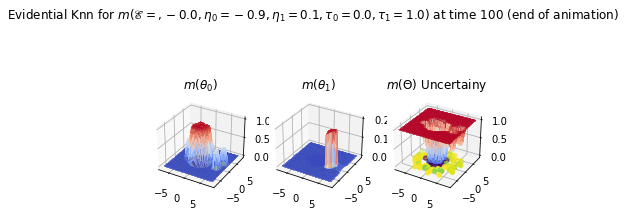

In [6]:

def predict_eknn_new(X_test = [4, 4], index=index, resx = res.x, my = my, t = t):
    D, I = index.search(np.ascontiguousarray(X_test, dtype=np.float32).reshape(1,2), k=5) # the full history is there if we do it like this
    T = 100 - t[I] # relative time difference of neighbor j to observation i
    result = predict_eknn(resx, I=I, D=D, my=my, T=T)
    return(result)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = .05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_to_assess = np.c_[xx.ravel(), yy.ravel()]

Z = np.apply_along_axis(predict_eknn_new, 1, grid_to_assess)

m1 = Z[:,0, 0].ravel().reshape(xx.shape)
m2 = Z[:,0, 1].ravel().reshape(xx.shape)
m3 = Z[:,0, 2].ravel().reshape(xx.shape)

from matplotlib import cm
import matplotlib.pyplot as plt
fig, (ax1,ax2,ax3) = plt.subplots(1,3, subplot_kw={"projection": "3d"})
ax1.set_title(r'$m(\theta_0)$')
ax1.plot_surface(xx, yy, m1,cmap=cm.coolwarm,linewidth=0, antialiased=False,alpha=.5, label = 'mass')
ax1.scatter(X[:,0], X[:,1],c=(my[:,0]+my[:,2]/2), label='training points')
ax2.set_title(r'$m(\theta_1)$')
ax2.plot_surface(xx, yy, m2,cmap=cm.coolwarm,linewidth=0, antialiased=False,alpha=.5, label = 'mass')
ax2.scatter(X[:,0], X[:,1],c=(my[:,0]+my[:,2]/2), label='training points')
ax3.set_title(r'$m(\Theta)$ Uncertainy')
ax3.plot_surface(xx, yy, m3,cmap=cm.coolwarm,linewidth=0, antialiased=False,alpha=.5, label = 'mass')
ax3.scatter(X[:,0], X[:,1],c=(my[:,0]+my[:,2]/2), label='training points')
fig.suptitle(r'Evidential Knn for $m(\mathscr{E} = , ' + str(round(res.x[0])) +
             r',\eta_0 = ' +str(round(res.x[1],  1)) +
             r', \eta_1 = ' +str(round(res.x[2], 1)) +
             r',\tau_0 = ' + str(round(res.x[3], 1)) +
             r',\tau_1 = ' + str(round(res.x[4], 1)) +
             r')$ at time 100 (end of animation)')
